In [13]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras==3.4.1
!pip install tensorflow==2.16.1

!unzip /content/drive/MyDrive/CandidaDataset_Filtered_NormGray2.zip -d CandidaDataset_Filtered_NormGray2
!unzip /content/drive/MyDrive/conflated.zip -d conflated

Archive:  /content/drive/MyDrive/CandidaDataset_Filtered_NormGray2.zip
replace CandidaDataset_Filtered_NormGray2/CandidaDataset_Filtered_NormGray2/13003p0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/conflated.zip
replace conflated/conflated/1723053358.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [14]:
import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from tensorflow import data as tf_data


SPLIT_RATIO = .2
BATCH_SIZE = 16
EPOCH = 50
IMG_SIZE = (320, 320)

class_ids = ["c.albicans"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

datapath = '/content/CandidaDataset_Filtered_NormGray2/CandidaDataset_Filtered_NormGray2/'
df = pd.read_csv(datapath + 'labels.csv', converters={"Locs": ast.literal_eval})

conflated_path = '/content/conflated/conflated/'
confl_df = pd.read_csv(conflated_path + 'conflated.csv', converters={"Locs": ast.literal_eval})

resizing = keras_cv.layers.Resizing(
    IMG_SIZE[0], IMG_SIZE[1],
    bounding_box_format="xyxy",
    pad_to_aspect_ratio=True
)

train_augmenter = keras.Sequential([keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format="xyxy")])

confl_augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format="xyxy"),
        keras_cv.layers.RandomRotation((-.5, .5), bounding_box_format="xyxy")
    ]
)

def load_data(df):
  train_labels = df["Locs"]
  train_labels = [np.array(x).reshape((-1,4)).astype(np.float16) for x in train_labels]
  train_paths = [datapath + x.split('/')[-1] for x in df["ID"]]

  train_paths, test_paths, train_labels, test_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
  test_paths, val_paths, test_labels, val_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42)

  train_classes = tf.ragged.constant(np.array([np.array([0 for box in im]) for im in train_labels], dtype=object))
  val_classes = tf.ragged.constant(np.array([np.array([0 for box in im]) for im in val_labels], dtype=object))
  test_classes = tf.ragged.constant(np.array([np.array([0 for box in im]) for im in test_labels], dtype=object))

  train_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(train_paths), train_classes, tf.ragged.constant(train_labels)))
  val_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(val_paths), val_classes, tf.ragged.constant(val_labels)))
  test_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(test_paths), test_classes, tf.ragged.constant(test_labels)))

  train_data = prep_dataset(train_data, is_train = True)
  val_data = prep_dataset(val_data)
  test_data = prep_dataset(test_data)

  return train_data, val_data, test_data

def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.per_image_standardization(image)
  return image

def load_dataset(image_path, classes, bbox):
  image = load_image(image_path)
  bounding_boxes = {
      "classes": classes,
      "boxes": bbox
  }
  return {"images": image, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

def prep_dataset(ds, is_train=False):
  ds = ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(BATCH_SIZE * 4)
  ds = ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
  if is_train:
    ds = ds.map(train_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    print(ds.cardinality().numpy())
    ds = ds.concatenate(prep_conflated())
    print(ds.cardinality().numpy())
  ds = ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

def prep_conflated():
  confl_labels = confl_df["Locs"]
  confl_labels = [np.array(x).reshape((-1,4)).astype(np.float16) for x in confl_labels]
  confl_paths = [conflated_path + x.split('/')[-1] for x in confl_df["ID"]]
  confl_classes = tf.ragged.constant(np.array([np.array([0 for box in im]) for im in confl_labels], dtype=object))
  confl_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(confl_paths), confl_classes, tf.ragged.constant(confl_labels)))
  confl_data = confl_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
  confl_data = confl_data.shuffle(BATCH_SIZE * 4)
  confl_data = confl_data.ragged_batch(BATCH_SIZE, drop_remainder=True)
  confl_data = confl_data.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
  confl_data = confl_data.map(train_augmenter, num_parallel_calls=tf_data.AUTOTUNE)
  for i in range(5):
    confl_data = confl_data.concatenate(confl_data.map(train_augmenter, num_parallel_calls=tf_data.AUTOTUNE))
  ds = confl_data.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  images, y_true = next(iter(ds.take(1)))
  visualization.plot_bounding_box_gallery(
    images*255,
    value_range=(0,255),
    rows=4,
    cols=4,
    y_true=y_true,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xyxy'
  )
  return confl_data

train_data, val_data, test_data = load_data(df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images, y_true = next(iter(train_data.take(1)))
visualization.plot_bounding_box_gallery(
    images*255,
    value_range=(0,255),
    rows=4,
    cols=4,
    y_true=y_true,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xyxy'
)

In [15]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path=None):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0
        self.epoch_num = 1

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        print(metrics, '\n')
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
        if self.save_path is not None:
          self.model.save(str(self.epoch_num) + self.save_path)
        self.epoch_num += 1
        return logs

    def on_test_end(self, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        print(metrics, '\n')
        logs.update(metrics)
        return logs

In [4]:
from google.colab import runtime

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=.4,
    confidence_threshold=0.5,
)

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=1,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3
)

yolo.summary()

optimizer = tf.keras.optimizers.Adam(
    learning_rate=.005,
    global_clipnorm=10.0,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou", run_eagerly=True
)

yolo.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[EvaluateCOCOMetricsCallback(val_data, save_path="model.h5")],
)

yolo.save('/content/drive/MyDrive/yolo_v16_filtered.h5')
yolo.save('/content/yolo_v16_filtered.h5')
yolo.save('/content/yolo_v16_filtered.keras')

100%|██████████| 647/647 [00:00<00:00, 747kB/s]


100%|██████████| 76.1M/76.1M [00:02<00:00, 32.4MB/s]


Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, None, None,    │     19,831,744 │ input_layer_1[0][0]    │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 512), (None,     │                │                        │
│                           │ None, None, 512)]      │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat (Repeat)           │ (None, None, None,     │              0 │ functional[0][2]       │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_1 (Repeat)         │ (None, None, None,     │              0 │ repeat[0][0]           │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ repeat_1[0][0],        │
│ (Concatenate)             │ 1024)                  │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │        524,288 │ concatenate_5[0][0]    │
│ (Conv2D)                  │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          2,048 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 256)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │        589,824 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │          1,024 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 256)                   │                │                        │
├──────────────────────

 Total params: 41,051,523 (156.60 MB)

 Trainable params: 41,007,107 (156.43 MB)

 Non-trainable params: 44,416 (173.50 KB)

Epoch 1/10


KeyboardInterrupt: 

In [9]:
yolo.evaluate(test_data, callbacks = [EvaluateCOCOMetricsCallback(test_data)], verbose=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 2.0912 {'MaP': <tf.Tensor: shape=(), dtype=float32, numpy=0.57701856>, 'MaP@[IoU=50]': <tf.Tensor: shape=(), dtype=float32, numpy=0.92161506>, 'MaP@[IoU=75]': <tf.Tensor: shape=(), dtype=float32, numpy=0.66369647>, 'MaP@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.43553823>, 'MaP@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.65296406>, 'MaP@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'Recall@[max_detections=1]': <tf.Tensor: shape=(), dtype=float32, numpy=0.45401302>, 'Recall@[max_detections=10]': <tf.Tensor: shape=(), dtype=float32, numpy=0.65661603>, 'Recall@[max_detections=100]': <tf.Tensor: shape=(), dtype=float32, numpy=0.65661603>, 'Recall@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.5235632>, 'Recall@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.73152>, 'Recall@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>} 

41/41 ━━━━━━━━━━━━━━━━━━━━ 16

[2.0634586811065674,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.57701856>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.92161506>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66369647>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65296406>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.43553823>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.73152>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5235632>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65661603>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65661603>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.45401302>]

In [16]:
import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
from keras_cv.src.models.object_detection.yolo_v8.yolo_v8_label_encoder import YOLOV8LabelEncoder

yolo = keras.models.load_model('/content/drive/MyDrive/yolo_v16_filtered.h5',
                                  custom_objects={'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
                                                  'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone,
                                                  'YOLOV8LabelEncoder': YOLOV8LabelEncoder,
                                                  'NonMaxSuppression': keras_cv.layers.NonMaxSuppression},
                                  compile = False)
optimizer = keras.optimizers.Adam(
    learning_rate=.005,
    global_clipnorm=10.0,
)
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou", run_eagerly=True
)


In [ ]:
#TEST
images, y_true = next(iter(test_data.take(3)))
print(np.mean(images[0]*255), np.std(images[0]*255))

test = plt.imread('/content/004126.jpg')
print(np.mean(test), np.std(test))

50.08466 10.024999
20.50781638191339 7.357984522179946


In [ ]:
images, y_true = next(iter(test_data.take(37)))
print(images[0])

tf.Tensor(
[[[-0.5489592  -0.5489592  -0.5489592 ]
  [-0.5489592  -0.5489592  -0.5489592 ]
  [-0.6168284  -0.6168284  -0.6168284 ]
  ...
  [-0.8883051  -0.8883051  -0.8883051 ]
  [-0.9561743  -0.9561743  -0.9561743 ]
  [-0.9561743  -0.9561743  -0.9561743 ]]

 [[-0.5489592  -0.5489592  -0.5489592 ]
  [-0.5489592  -0.5489592  -0.5489592 ]
  [-0.6168284  -0.6168284  -0.6168284 ]
  ...
  [-0.9561743  -0.9561743  -0.9561743 ]
  [-0.9561743  -0.9561743  -0.9561743 ]
  [-1.0240434  -1.0240434  -1.0240434 ]]

 [[-0.5489592  -0.5489592  -0.5489592 ]
  [-0.5489592  -0.5489592  -0.5489592 ]
  [-0.6168284  -0.6168284  -0.6168284 ]
  ...
  [-0.9561743  -0.9561743  -0.9561743 ]
  [-0.9561743  -0.9561743  -0.9561743 ]
  [-1.0240434  -1.0240434  -1.0240434 ]]

 ...

 [[-0.14174408 -0.14174408 -0.14174408]
  [-0.14174408 -0.14174408 -0.14174408]
  [-0.14174408 -0.14174408 -0.14174408]
  ...
  [-0.34535164 -0.34535164 -0.34535164]
  [-0.41322082 -0.41322082 -0.41322082]
  [-0.41322082 -0.41322082 -0.413

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images*255,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        y_true=y_true,
        scale=4,
        rows=4,
        cols=4,
        show=True,
        font_scale=0.7,
    )


visualize_detections(yolo, dataset=test_data, bounding_box_format="xyxy")

Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step


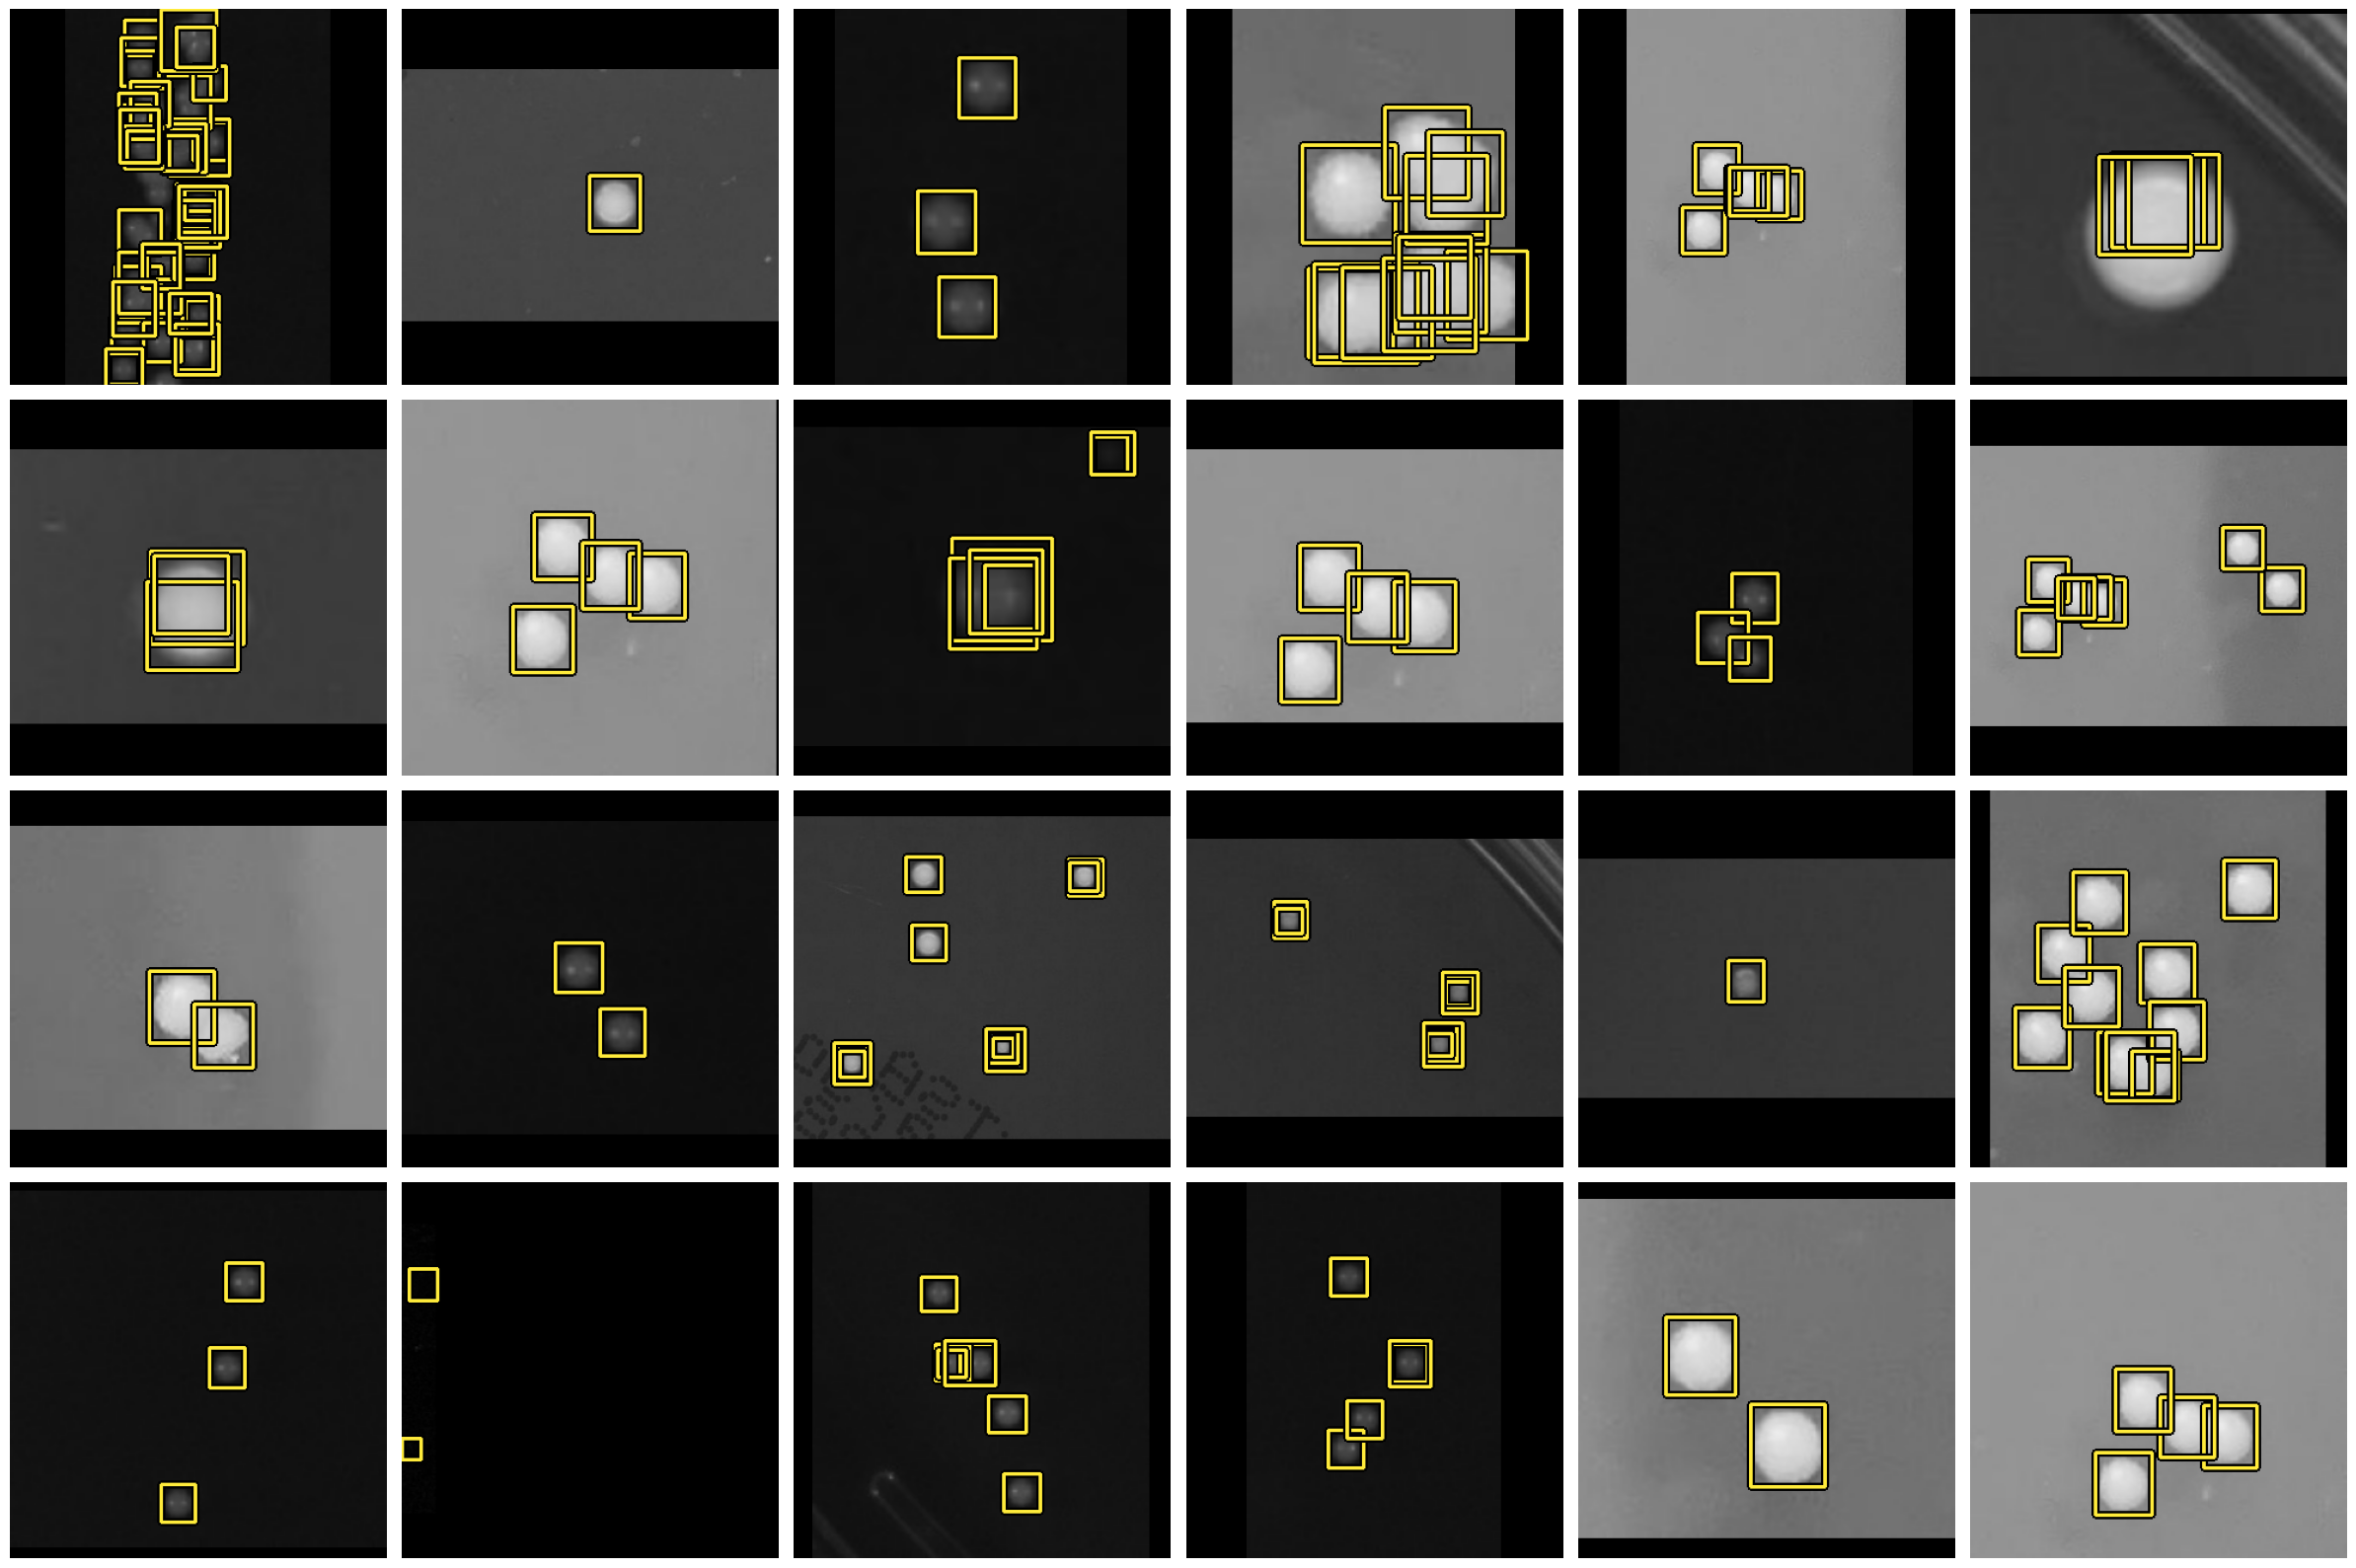

In [17]:
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np

originals = []
images = []
for fl in os.listdir('/content/'):
  if fl.endswith('.jpg'):
    orig = plt.imread('/content/' + fl)
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    orig = np.stack((orig,)*3, axis=-1)
    orig = tf.image.resize_with_pad(orig, 320, 320)
    img = tf.image.per_image_standardization(orig)
    img = tf.expand_dims(img, axis=0)
    originals.append(orig)
    images.append(img)

batch = tf.concat(images, 0)
pred  = yolo.predict(batch)
visualization.plot_bounding_box_gallery(
        originals,
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_pred=pred,
        scale=4,
        rows=4,
        cols=6,
        show=True,
        font_scale=0
        )

# orig = plt.imread('/content/708916.jpg')
# orig = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
# orig = np.stack((orig,)*3, axis=-1)
# orig = tf.image.resize_with_pad(orig, 320, 320)
# img = tf.image.per_image_standardization(orig)
# img = tf.expand_dims(img, axis=0)
# pred = yolo.predict(tf.convert_to_tensor(img, dtype = tf.float32))
# print(pred)
# plt.imshow(img[0])
# plt.show()
# visualization.plot_bounding_box_gallery(
#         [orig],
#         value_range=(0, 255),
#         bounding_box_format='xyxy',
#         y_pred=pred,
#         scale=4,
#         rows=1,
#         cols=1,
#         show=True,
#         font_scale=0.7,
#     )